In [1]:
import timm
from torchinfo import summary
import torch
from torch import nn
import torch.nn.functional as F
from importlib import reload
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import albumentations
from albumentations import augmentations
import albumentations.pytorch
from tqdm import tqdm
from torch.utils.data import DataLoader

In [8]:
from utils import get_dataframe
casia128 = get_dataframe('dataset_csv/casia_128.csv', folds=41)['label' == 0]
imd128 = get_dataframe('dataset_csv/imd_128.csv', folds=41)
cmfd128 = get_dataframe('dataset_csv/cmfd_128.csv', folds=-1)
coverage128 = get_dataframe('dataset_csv/coverage_128.csv', folds=12)
nist128 = get_dataframe('dataset_csv/nist16_128.csv', folds=15)

df_128 = pd.concat([casia128, imd128, cmfd128, nist128, coverage128])

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     # print(coverage128.groupby('fold').label.value_counts())
#     print(nist128.label.value_counts())
#     print(df_128.groupby(['root_dir','fold']).label.value_counts())

In [12]:
skip = []
for row in tqdm(df_128.values):
    image_name, image_patch, mask_patch, label, _, ela, root_dir = row
    image_path = os.path.join('Image_Manipulation_Dataset', root_dir, image_name, image_patch)
    ela_path = os.path.join('Image_Manipulation_Dataset', root_dir, image_name, ela)
    if mask_patch != '':
        mask_path = os.path.join('Image_Manipulation_Dataset', root_dir, image_name, mask_patch)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if "NIST" in root_dir: mask = 255 - mask

        if(label == 1 and np.count_nonzero(mask) < 50): skip.append(mask_path)


100%|██████████| 258849/258849 [00:54<00:00, 4746.33it/s]


In [2]:
pd.options.display.max_rows = 4000
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=np.inf)

In [20]:
import classifier
reload(classifier)
from classifier import ClassifierConv
c = ClassifierConv(21*448)
summary(c, (21*448,8,8), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─SeparableConvBnAct: 1-1                [-1, 2352, 8, 8]          --
|    └─Conv2d: 2-1                       [-1, 9408, 8, 8]          84,672
|    └─Conv2d: 2-2                       [-1, 2352, 8, 8]          22,127,616
|    └─BatchNormAct2d: 2-3               [-1, 2352, 8, 8]          --
|    |    └─ReLU: 3-1                    [-1, 2352, 8, 8]          --
├─MaxPool2d: 1-2                         [-1, 2352, 6, 6]          --
├─Dropout2d: 1-3                         [-1, 2352, 6, 6]          --
├─SeparableConvBnAct: 1-4                [-1, 1568, 6, 6]          --
|    └─Conv2d: 2-4                       [-1, 2352, 6, 6]          21,168
|    └─Conv2d: 2-5                       [-1, 1568, 6, 6]          3,687,936
|    └─BatchNormAct2d: 2-6               [-1, 1568, 6, 6]          --
|    |    └─ReLU: 3-2                    [-1, 1568, 6, 6]          --
├─MaxPool2d: 1-5                         [-1, 1568, 4, 4]     

Layer (type:depth-idx)                   Output Shape              Param #
├─SeparableConvBnAct: 1-1                [-1, 2352, 8, 8]          --
|    └─Conv2d: 2-1                       [-1, 9408, 8, 8]          84,672
|    └─Conv2d: 2-2                       [-1, 2352, 8, 8]          22,127,616
|    └─BatchNormAct2d: 2-3               [-1, 2352, 8, 8]          --
|    |    └─ReLU: 3-1                    [-1, 2352, 8, 8]          --
├─MaxPool2d: 1-2                         [-1, 2352, 6, 6]          --
├─Dropout2d: 1-3                         [-1, 2352, 6, 6]          --
├─SeparableConvBnAct: 1-4                [-1, 1568, 6, 6]          --
|    └─Conv2d: 2-4                       [-1, 2352, 6, 6]          21,168
|    └─Conv2d: 2-5                       [-1, 1568, 6, 6]          3,687,936
|    └─BatchNormAct2d: 2-6               [-1, 1568, 6, 6]          --
|    |    └─ReLU: 3-2                    [-1, 1568, 6, 6]          --
├─MaxPool2d: 1-5                         [-1, 1568, 4, 4]     

In [27]:
print("Parameters : ", sum(p.numel() for p in ui.parameters() if p.requires_grad))

Parameters :  25220411


In [5]:
import re
ckpt = torch.load('weights/pretrain_[31|03_12|16|32].h5')
# print(ckpt.keys())
sd = {re.sub("^module.", "", k): v for k, v in ckpt.items()}
print(sd.keys())

dict_keys(['srm_conv.weight', 'bayer_conv.weight', 'rgb_conv.0.weight', 'rgb_conv.1.weight', 'ela_net.0.weight', 'ela_net.1.weight', 'encoder.stem.0.weight', 'encoder.stem.1.weight', 'encoder.stem.1.bias', 'encoder.stem.1.running_mean', 'encoder.stem.1.running_var', 'encoder.stem.1.num_batches_tracked', 'encoder.blocks.3.0.conv_dw.weight', 'encoder.blocks.3.0.bn1.weight', 'encoder.blocks.3.0.bn1.bias', 'encoder.blocks.3.0.bn1.running_mean', 'encoder.blocks.3.0.bn1.running_var', 'encoder.blocks.3.0.bn1.num_batches_tracked', 'encoder.blocks.3.0.se.conv_reduce.weight', 'encoder.blocks.3.0.se.conv_reduce.bias', 'encoder.blocks.3.0.se.conv_expand.weight', 'encoder.blocks.3.0.se.conv_expand.bias', 'encoder.blocks.3.0.conv_pw.weight', 'encoder.blocks.3.0.bn2.weight', 'encoder.blocks.3.0.bn2.bias', 'encoder.blocks.3.0.bn2.running_mean', 'encoder.blocks.3.0.bn2.running_var', 'encoder.blocks.3.0.bn2.num_batches_tracked', 'encoder.blocks.3.1.conv_dw.weight', 'encoder.blocks.3.1.bn1.weight', 'enco

In [3]:
from segmentation.merged_net import SRM_Classifer

merged = SRM_Classifer()
print(merged.state_dict().keys())

odict_keys(['srm_conv.weight', 'bayer_conv.weight', 'rgb_conv.0.weight', 'rgb_conv.1.weight', 'ela_net.0.weight', 'ela_net.1.weight', 'encoder.stem.0.weight', 'encoder.stem.1.weight', 'encoder.stem.1.bias', 'encoder.stem.1.running_mean', 'encoder.stem.1.running_var', 'encoder.stem.1.num_batches_tracked', 'encoder.blocks.3.0.conv_dw.weight', 'encoder.blocks.3.0.bn1.weight', 'encoder.blocks.3.0.bn1.bias', 'encoder.blocks.3.0.bn1.running_mean', 'encoder.blocks.3.0.bn1.running_var', 'encoder.blocks.3.0.bn1.num_batches_tracked', 'encoder.blocks.3.0.se.conv_reduce.weight', 'encoder.blocks.3.0.se.conv_reduce.bias', 'encoder.blocks.3.0.se.conv_expand.weight', 'encoder.blocks.3.0.se.conv_expand.bias', 'encoder.blocks.3.0.conv_pw.weight', 'encoder.blocks.3.0.bn2.weight', 'encoder.blocks.3.0.bn2.bias', 'encoder.blocks.3.0.bn2.running_mean', 'encoder.blocks.3.0.bn2.running_var', 'encoder.blocks.3.0.bn2.num_batches_tracked', 'encoder.blocks.3.1.conv_dw.weight', 'encoder.blocks.3.1.bn1.weight', 'enc

In [2]:
# reload(segmentation.timm_unetb4)
from segmentation.timm_unetb4 import UnetB4, UnetB4_Inception
from segmentation.timm_unetpp import UnetPP
from segmentation.timm_efficientnet import EfficientNet

# unetpp = UnetPP(encoder=EfficientNet().get_encoder())
unetb4 = UnetB4(encoder=EfficientNet().get_encoder())
# unetb4_inc = UnetB4_Inception(encoder=EfficientNet().get_encoder())

In [8]:
z = torch.nn.functional.adaptive_avg_pool1d(out.permute(0,2,1), 1).squeeze()
z.shape

torch.Size([4, 1792])

In [9]:
# y = torch.mean(out,dim=1,keepdims=True)
# print(y.shape)
print(z.shape)
mlp = nn.Sequential(
    nn.Linear(1792, 1792 // 16, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1792 // 16, 1792, bias=True),
    nn.ReLU(inplace=True)
)
y = mlp(z)
print(y.shape)
# y = y*out
# print(y.shape)

torch.Size([4, 1792])
torch.Size([4, 1792])


In [23]:
import classifier
reload(classifier)
from classifier import Classifier_GAP
clf = Classifier_GAP(1792)
y = clf(out)
print(y.shape)
print(y)
print("Parameters : ", sum(p.numel() for p in clf.parameters() if p.requires_grad))

torch.Size([4, 1])
tensor([[0.0159],
        [0.0171],
        [0.0597],
        [0.0110]], grad_fn=<AddmmBackward>)
Parameters :  405105


In [2]:
import classifier_dataset
reload(classifier_dataset)
from classifier_dataset import Classifier_Dataset

DATA_ROOT = f"Image_Manipulation_Dataset/CASIA_2.0/1792_tensors"
df = pd.read_csv(f"casia_1792_tensors.csv").sample(frac=1).reset_index(drop=True)
dataset = Classifier_Dataset(
    dataframe=df,
    mode="train",
    val_fold=0,
    test_fold=9,
    root_dir=DATA_ROOT,
    equal_sample=False,
)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

real:2400, fakes:2400, mode = train


In [57]:
class Classifier2(nn.Module):
    def __init__(self, in_channels):
        super(Classifier2, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
    def forward(self, x):
        print(x.size())
        y = x.permute((0,2,1))
        print(y.size())
        y = self.gap1D(y).squeeze(-1)
        print(y.size())
        y = self.mlp(y).unsqueeze(1)
        x =  x * y
        print(x.size())
        # x = nn.functional.dropout(x, p=0.3)
        x = x.permute((0,2,1))
        print(x.size())
        x = self.gap1D(x).squeeze(-1)
        print(x.size())
        x = self.fc(x)
        print(x.size())
        return x
cls = Classifier2(32)

In [55]:
class Classifierold(nn.Module):
    def __init__(self, in_channels):
        super(Classifierold, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
        
    def forward(self, x):
        y = x.T.unsqueeze(0)
        y = self.gap1D(y).squeeze(-1)
        y = self.mlp(y)
        x =  x * y
        
        # x = nn.functional.dropout(x, p=0.3)
        x = x.T.unsqueeze(0)
        x = self.gap1D(x).squeeze(-1)
        
        x = self.fc(x)
        
        return x
clso = Classifierold(32)

(5, 6, 224, 224)


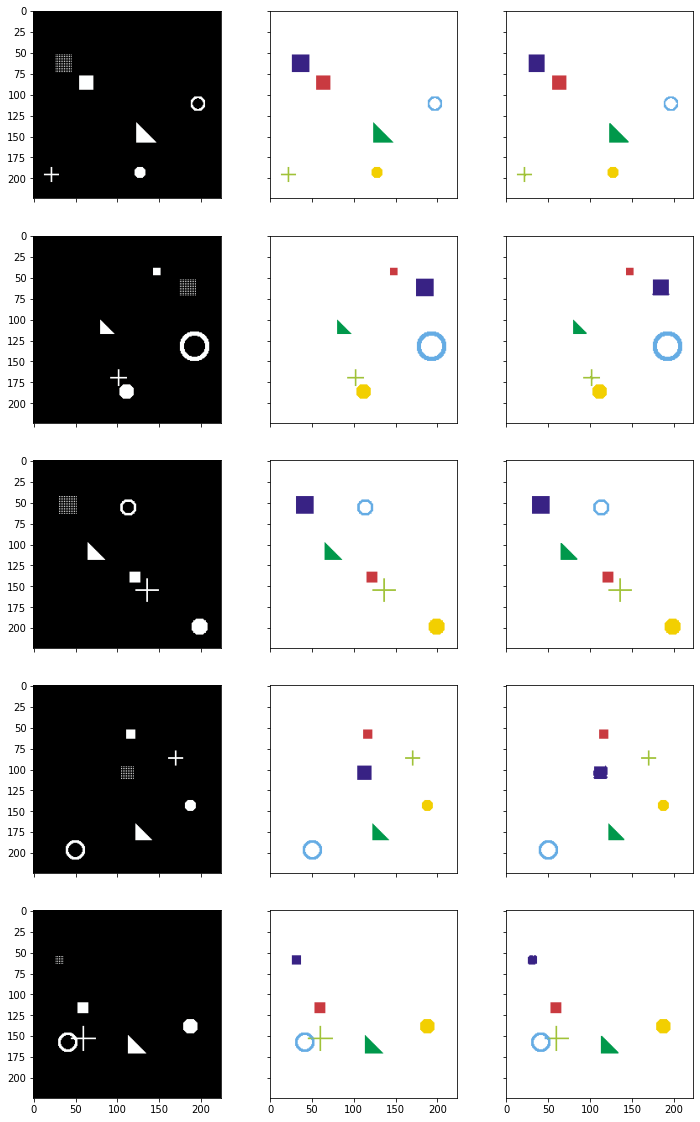

In [17]:
# import segmentation_models_pytorch as smp
# from segmentation.smp_effb4 import SMP_DIY
# from segmentation.timm_unetb4 import UnetB4
from segmentation.timm_srm_unetpp import UnetPP
from segmentation.merged_net import SRM_Classifer 
# from segmentation.timm_efficientnet import EfficientNet
from sim_dataset import SimDataset
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import simulation_helper
from torchvision import transforms

device = 'cuda'
encoder = SRM_Classifer()
model = UnetPP(encoder, num_classes=6, sampling='nearest', layer='end')
model = nn.DataParallel(model)
model.load_state_dict(torch.load('weights/simulationUnetPP_[21|04_21|52|04].h5'))
model.to(device)
model.eval()   # Set model to the evaluation mode

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])
# Create another simulation dataset for test
test_dataset = SimDataset(5, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)

# Get the first batch
data = next(iter(test_loader))
inputs = data['image'].to(device)
labels = data['mask'].to(device)
elas = data['ela'].to(device)


# Predict
pred = model(inputs, elas)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().detach().numpy()
print(pred.shape)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [simulation_helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [simulation_helper.masks_to_colorimg(x) for x in pred]

simulation_helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [13]:
from collections import OrderedDict
ld = torch.load('best_weights/CASIA_64_ELA.h5')
newdict = OrderedDict()
for x in ld.keys():
    if 'base_model' in x:
        z = x.replace('.base_model','')
        newdict[z] = ld[x]
    else:
        newdict[x] = ld[x]

Dice Loss:0.09562963247299194
Dice:0.9043703675270081, IOU:0.8254343867301941, Label:tensor([[0.8948]])


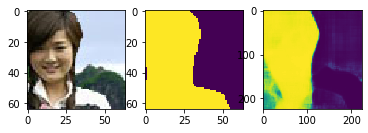

Dice Loss:0.535085916519165
Dice:0.4649140536785126, IOU:0.3028586506843567, Label:tensor([[0.8976]])


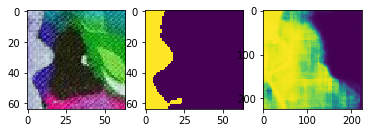

Dice Loss:0.02807760238647461
Dice:0.9719223976135254, IOU:0.9453784823417664, Label:tensor([[0.9058]])


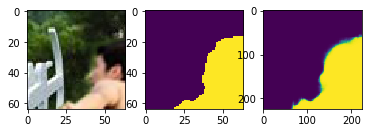

Dice Loss:0.191489577293396
Dice:0.808510422706604, IOU:0.6785711646080017, Label:tensor([[0.9010]])


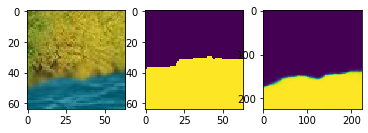

Dice Loss:0.0478367805480957
Dice:0.9521632194519043, IOU:0.9086941480636597, Label:tensor([[0.8936]])


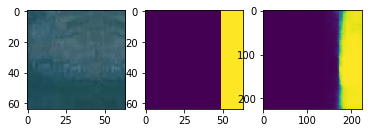

Dice Loss:0.3708534836769104
Dice:0.6291465163230896, IOU:0.4589451551437378, Label:tensor([[0.8816]])


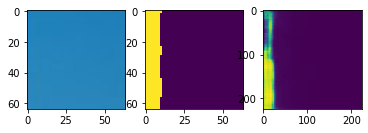

Dice Loss:0.16058605909347534
Dice:0.8394139409065247, IOU:0.7232673168182373, Label:tensor([[0.8668]])


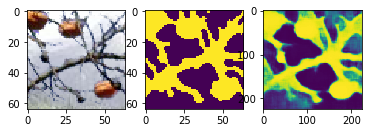

Dice Loss:0.009598791599273682
Dice:0.9904012084007263, IOU:0.9809849262237549, Label:tensor([[0.8979]])


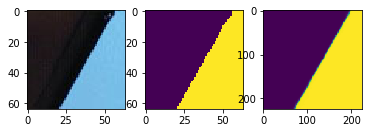

Dice Loss:0.012291967868804932
Dice:0.9877080321311951, IOU:0.9757145643234253, Label:tensor([[0.8984]])


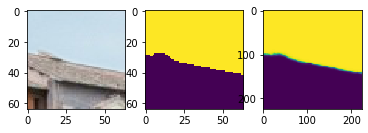

Dice Loss:0.047695934772491455
Dice:0.9523040652275085, IOU:0.9089508056640625, Label:tensor([[0.9021]])


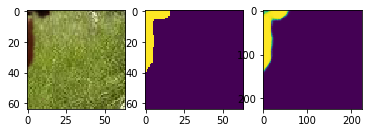

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.6628]])


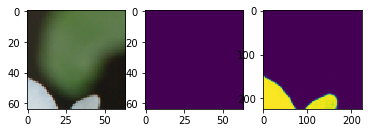

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1002]])


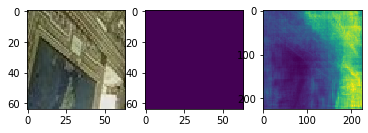

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0965]])


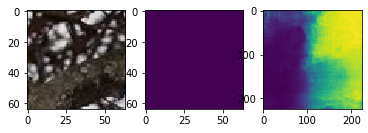

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0975]])


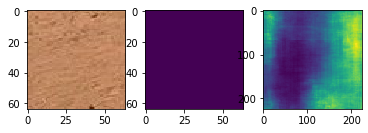

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1007]])


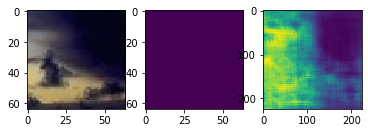

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1010]])


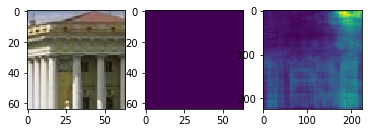

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1001]])


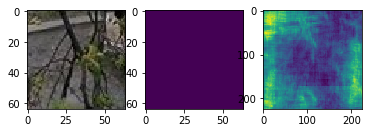

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0943]])


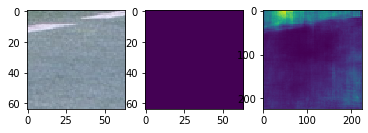

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0982]])


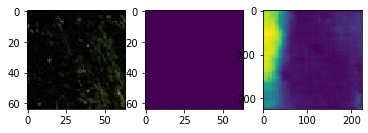

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0970]])


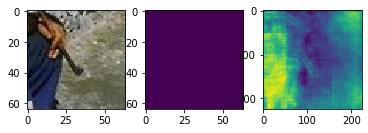

Total Dice:0.0, Total IOU:0.0
Best Dice: -1, Count = 0.0, IDX : 0
Best IOU: -1, Count = 0.0, IDX : 0
Total Dice2:0.0, Total IOU2:0.0


In [26]:
from pytorch_toolbelt import losses
from utils import *
import seg_metrics

root_dir = 'Image_Manipulation_Dataset/CASIA_2.0/image_patch_64'
for row in data:
    image_name, image_patch, mask_patch, label, fold, ela = row

    image_path = os.path.join(root_dir, image_name, image_patch)
    ela_path = os.path.join(root_dir, image_name, ela)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    ela_image = cv2.imread(ela_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2RGB)

    if not isinstance(mask_patch, str) and np.isnan(mask_patch):
        mask_image = np.zeros((image.shape[0], image.shape[1]))
    else:
        mask_path = os.path.join(root_dir, image_name, mask_patch)
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    trans = valid_aug(image=image, mask=mask_image, ela=ela_image)
    tensor = trans["image"].unsqueeze(0).cuda()
    mask_tensor = trans["mask"].unsqueeze(0).cuda()
    ela_tensor = trans["ela"].unsqueeze(0).cuda()

    dice_tot = AverageMeter()
    jaccard_tot = AverageMeter()
    preds = []
    targets = []
    labels = []
    with torch.no_grad():
        out_label, _ = classifier(tensor, ela_tensor)
        out_label = F.logsigmoid(out_label.cpu()).exp()

        out_mask = localizer(tensor, ela_tensor)
        out_mask = F.logsigmoid(out_mask.cpu()).exp()
        mask_tensor = mask_tensor.cpu()

        dice = losses.functional.soft_dice_score(out_mask, mask_tensor)
        dice_tot.update(dice)
        jaccard = losses.functional.soft_jaccard_score(out_mask, mask_tensor)
        jaccard_tot.update(jaccard)

        preds.append(out_mask)
        targets.append(mask_tensor)
        labels.append(out_label)

    loss = losses.DiceLoss(mode='binary', log_loss=False, from_logits=False)
    dice_loss = loss(out_mask, mask_tensor)
    print(f"Dice Loss:{dice_loss}")
    print(f"Dice:{dice}, IOU:{jaccard}, Label:{out_label}")
    plt.figure(1)
    plt.subplot(131)
    plt.imshow(image)

    plt.subplot(132)
    plt.imshow(mask_image)

    plt.subplot(133)
    plt.imshow(image2np(out_mask.squeeze(0)))
    plt.show()

print(f"Total Dice:{dice_tot.avg}, Total IOU:{jaccard_tot.avg}")
dice_tot2, best_dice = seg_metrics.dice_coeff(preds, targets)  
jaccard_tot2, best_iou = seg_metrics.jaccard_coeff(preds, targets) 
print(f"Total Dice2:{dice_tot2.item()}, Total IOU2:{jaccard_tot2.item()}")

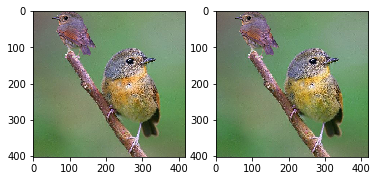

In [25]:
import imgaug.augmenters as iaa
aug = iaa.AddToHue(-250)

img = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/Tp/Tp_D_NNN_S_N_ani10201_ani10200_12412.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img = aug.augment_image(image=img)

plt.figure(1)
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(new_img)

plt.show()

In [13]:
import albumentations
import albumentations.pytorch

image = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ela = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/ela_1.png')
ela = cv2.cvtColor(ela, cv2.COLOR_BGR2RGB)

mask = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1_gt.png', cv2.IMREAD_GRAYSCALE)
# mask = np.expand_dims(mask, 2)

# mask_tensor = torch.from_numpy(mask.transpose(2, 0, 1))
# print(mask_tensor.shape, mask_tensor.type())

# plt.figure(figsize=(10,20))
# plt.subplot(1,3,1)
# plt.imshow(image)
# plt.subplot(1,3,2)
# plt.imshow(ela)
# plt.subplot(1,3,3)
# plt.imshow(mask)
# plt.show()

image = augmentations.geometric.functional.resize(image, 256, 256, cv2.INTER_AREA)
mask = augmentations.geometric.functional.resize(mask, 256, 256, cv2.INTER_AREA)
ela = augmentations.geometric.functional.resize(ela, 256, 256, cv2.INTER_AREA)

print(image.shape, image.dtype)
print(ela.shape, ela.dtype)
print(mask.shape, mask.dtype)

(256, 256, 3) uint8
(256, 256, 3) uint8
(256, 256) uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([3, 256, 256]) torch.FloatTensor
torch.Size([3, 256, 256]) torch.FloatTensor
torch.Size([256, 256]) torch.FloatTensor


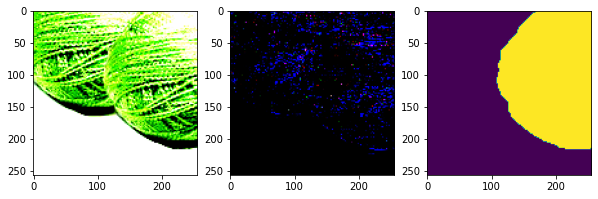

In [5]:
normalize = {
    "mean": [0.4535, 0.4286, 0.4178],
    "std": [0.2673, 0.2550, 0.2947],
}

transforms_normalize = albumentations.Compose(
    [
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    additional_targets={'ela':'image'}
)

data = transforms_normalize(image=image, mask=mask, ela=ela)
aug_image = data["image"]
aug_mask = data["mask"] / 255.0
aug_ela = data["ela"]

print(aug_image.shape, aug_image.type())
print(aug_ela.shape, aug_ela.type())
print(aug_mask.shape, aug_mask.type())

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(aug_image.permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(aug_ela.permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(aug_mask)
plt.show()

In [25]:
from torchvision.transforms import functional as F

tensor_image = F.to_tensor(image)
tensor_ela = F.to_tensor(ela)
# tensor_mask = transTensor(mask)

# print(tensor_image.shape, tensor_image.type())
# print(tensor_ela.shape, tensor_ela.type())
# print(tensor_mask.shape, tensor_mask.type())

# ELA
# mean:[0.0640, 0.0525, 0.0767]
# std:[0.0870, 0.0722, 0.1013]

normal_image = F.normalize(tensor_image, mean=[0.4535, 0.4286, 0.4178], std=[0.2673, 0.2550, 0.2947])
normal_ela_old = F.normalize(tensor_ela, mean=[0.4535, 0.4286, 0.4178], std=[0.2673, 0.2550, 0.2947])
normal_ela_new = F.normalize(tensor_ela, mean=[0.0640, 0.0525, 0.0767], std=[0.0870, 0.0722, 0.1013])
# plt.figure(figsize=(10,20))
# plt.subplot(1,3,1)
# plt.imshow(normal_image.permute(1,2,0))
# plt.subplot(1,3,2)
# plt.imshow(tensor_ela.permute(1,2,0))
# plt.subplot(1,3,3)
# plt.imshow(tensor_mask.permute(1,2,0))
# plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


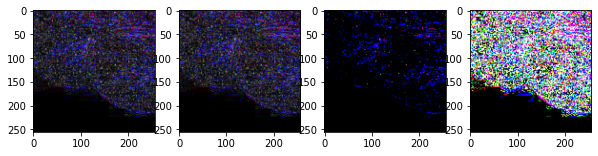

In [29]:
# plt.figure(figsize=(10,20))
# plt.subplot(1,3,1)
# plt.imshow(image)
# plt.subplot(1,3,2)
# plt.imshow(tensor_image.permute(1,2,0))
# plt.subplot(1,3,3)
# plt.imshow(normal_image.permute(1,2,0))
# plt.show()

plt.figure(figsize=(10,20))
plt.subplot(1,4,1)
plt.imshow(ela)
plt.subplot(1,4,2)
plt.imshow(tensor_ela.permute(1,2,0))
plt.subplot(1,4,3)
plt.imshow(normal_ela_old.permute(1,2,0))
plt.subplot(1,4,4)
plt.imshow(normal_ela_new.permute(1,2,0))
plt.show()

real:1058, fakes:1058, mode = val
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([32, 3, 256, 256]) torch.FloatTensor
torch.Size([32, 3, 256, 256]) torch.FloatTensor
torch.Size([32]) torch.DoubleTensor
torch.Size([32, 1, 256, 256]) torch.FloatTensor


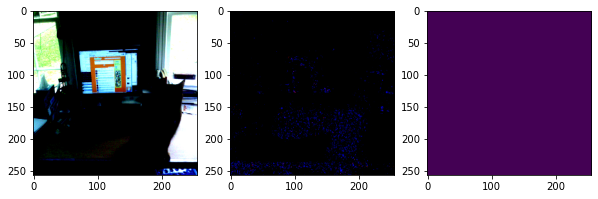

In [18]:
df = pd.read_csv(f"combo_all_FULL.csv", keep_default_na=False).sample(frac=1.0, random_state=123).reset_index(drop=True)

import dataset
reload(dataset)
from dataset import DATASET
import albumentations.pytorch

valid_dataset = DATASET(
    dataframe=df,
    mode="val",
    val_fold=0,
    test_fold=1,
    patch_size='FULL',
    transforms_normalize=None,
)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=16, pin_memory=True, drop_last=False)

for batch in valid_loader:
    images = batch["image"]
    elas = batch["ela"]
    target_labels = batch["label"]
    gt = batch["mask"]

    print(images.shape, images.type())
    print(elas.shape, elas.type())
    print(target_labels.shape, target_labels.type())
    print(gt.shape, gt.type())

    plt.figure(figsize=(10,20))
    plt.subplot(1,3,1)
    plt.imshow(images[0].permute(1,2,0))
    plt.subplot(1,3,2)
    plt.imshow(elas[0].permute(1,2,0))
    plt.subplot(1,3,3)
    plt.imshow(gt[0].squeeze())
    plt.show()

    # print(gt[0])
    break

In [6]:
from torch.utils.data import Dataset, DataLoader
import albumentations
import albumentations.pytorch
import numpy as np

from segmentation.merged_net import SRM_Classifer

class DATASET(Dataset):
    def __init__(self):
        super().__init__()
        self.image = [np.random.randint(low=0, high=256, size=(256,256,3)) for i in range(32)]
        self.ela = [np.random.randint(low=0, high=256, size=(256,256,3)) for i in range(32)]
        self.mask = [np.random.randint(low=0, high=2, size=(256,256)) for i in range(32)]

        self.normalize = {
            "mean": [0.4535, 0.4286, 0.4178],
            "std": [0.2675, 0.2550, 0.2947],
        }
        self.train_aug = albumentations.Compose(
            [
                # albumentations.augmentations.geometric.resize.Resize(256, 256, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
                # albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
                albumentations.pytorch.transforms.ToTensorV2()
            ],
            additional_targets={'ela':'image'}
        )

    def __len__(self):
        return len(self.image)

    def __getitem__(self, index: int):
        
        # print(self.image[index].shape)
        # print(self.ela[index].shape)
        # print(self.mask[index].shape)
        

        data = self.train_aug(image=self.image[index], mask=self.mask[index], ela=self.ela[index])
        aug_image = data["image"]
        aug_mask = data["mask"]
        aug_ela = data["ela"]

        return {
            "image": aug_image,
            "ela" : aug_ela, 
            "mask": aug_mask
        }
dataset = DATASET()        
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

model = SRM_Classifer()

i = 0
for batch in loader:
    images = batch["image"]
    elas = batch["ela"]
    masks = batch["mask"]

    print(i, "------------")
    print(images.shape)
    print(elas.shape)
    print(masks.shape)
    
    i+=1

    output 


0 ------------
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])
1 ------------
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])
2 ------------
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])
3 ------------
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


In [11]:
np.zeros((image.shape[0], image.shape[1])).dtype

dtype('float64')

In [3]:
import dataset
reload(dataset)
from dataset import DATASET
import albumentations.pytorch

df = pd.read_csv(f"combo_all_FULL.csv").sample(frac=1.0).reset_index(drop=True)

normalize = {
    "mean": [0.4535408213875562, 0.42862278450748387, 0.41780105499276865],
    "std": [0.2672804038612597, 0.2550410416463668, 0.29475415579144293],
}
train_geo_aug = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.RandomRotate90(p=0.1),
        albumentations.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=35, p=0.25),
    ],
    additional_targets={'ela':'image'}
)
transforms_normalize = albumentations.Compose(
    [
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    additional_targets={'ela':'image'}
)
train_dataset = DATASET(
    dataframe=df,
    mode="train",
    val_fold=0,
    test_fold=1,
    patch_size="FULL",
    resize=256,
    transforms_normalize=transforms_normalize,
    imgaug_augment=None,
    geo_augment=train_geo_aug
)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=16, pin_memory=True, drop_last=False)

real:10511, fakes:8173, mode = train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
dict_keys(['image', 'image_path', 'label', 'mask', 'ela'])
torch.Size([3, 256, 256]) torch.FloatTensor
torch.Size([256, 256]) torch.FloatTensor
torch.Size([3, 256, 256]) torch.FloatTensor


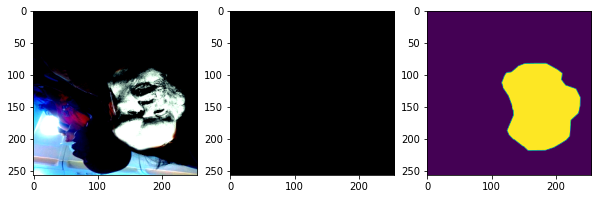

In [19]:
data = train_dataset[1112]
print(data.keys())
print(data['image'].shape, data['image'].type())
print(data['mask'].shape, data['mask'].type())
print(data['ela'].shape, data['ela'].type())

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(data['image'].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(data['ela'].permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(data['mask'])
plt.show()

In [21]:
data_fake1 = train_dataset[1]
data_fake2 = train_dataset[2]
data_fake3 = train_dataset[1112]

data_real1 = train_dataset[0]
data_real2 = train_dataset[4]
data_real3 = train_dataset[5]

def get_mask(data):
    return data['mask'].unsqueeze(0)

In [68]:
np.random.rand()

0.28537605105744945

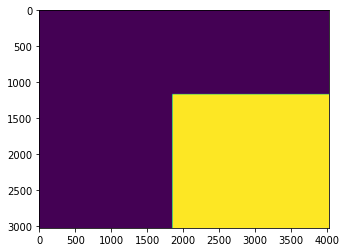

In [6]:
mask_image = cv2.imread('Image_Manipulation_Dataset/NIST16/nist16_full/mask/removal_NC2016_0587.jpg', cv2.IMREAD_GRAYSCALE)
mask_image = 255 - mask_image
plt.figure()
plt.imshow(mask_image)
plt.show()

In [56]:
from pytorch_toolbelt import losses
import seg_metrics

# print(get_mask(data_real1).shape)

fake_mask = torch.cat([get_mask(data_fake1).unsqueeze(0), get_mask(data_fake2).unsqueeze(0), get_mask(data_fake3).unsqueeze(0)], axis=0)
print(fake_mask.shape)
fake_mask[1].shape
# dice = DiceLoss(mode='binary', from_logits=False, smooth=1e-7, log_loss=True)
# dice = 0
# for i, c in enumerate(zip(fake_mask, fake_mask)):
#     print(c[0].shape, c[1].shape)
#     print(losses.functional.soft_dice_score(c[0].to('cuda'), c[1].to('cuda'), smooth=1e-7).item())
# print(dice / fake_mask.shape[0])
# dice(mask_real.to('cuda'), mask_fake.to('cuda'))

torch.Size([3, 1, 256, 256])


torch.Size([1, 256, 256])

## DICE Testing

In [117]:
import torch
import numpy as np 

x = [[0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0]]

y1 = [[0,0,0,0,0,0,0,0],
      [0,0.75,0.89,0.95,0,0,0,0],
      [0,0.66,0.92,0.93,0,0,0,0],
      [0,0.75,0.77,0.91,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0]]

y2 = [[0,0,0,0,0,0,0,0],
      [0,0.75,0.89,0.95,0,0,0,0],
      [0,0.66,0.92,0.93,0,0,0,0],
      [0,0.75,0.77,0.16,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0.01,0.2,0],
      [0,0,0,0,0,0.15,0.11,0]]

gt = torch.tensor(x).unsqueeze(0).float()
out1 = torch.tensor(y1).unsqueeze(0).float()
out2 = torch.tensor(y2).unsqueeze(0).float()

label = torch.stack([gt, gt])
pred = torch.stack([out1, out2])

In [124]:
"a/b/c/d/e".split('/', 2)

['a', 'b', 'c/d/e']

In [118]:
import seg_metrics
reload(seg_metrics)
from seg_metrics import get_fpr

get_fpr(pred, label)

(0.1328125, (0.125, 1), (0.140625, 0))

In [22]:
# from pytorch_toolbelt.losses import dice
# reload(dice)

from toolbelt_DiceLoss import DiceLoss

dice = DiceLoss(mode='binary', log_loss=True, smooth=1e-7, from_logits=False)
dice(pred.float().cuda(), label.float().cuda())

-> tensor([2.5000e-08], device='cuda:0')


tensor(16.1181, device='cuda:0')

In [10]:
from losses import DiceLoss, ImanipLoss
from torch import nn
from torch.nn.modules.loss import _Loss
class ImanipLoss(_Loss):

    def __init__(self, bce: nn.Module, dice: nn.Module):
        super().__init__()
        self.bce = bce
        self.dice = dice

    def forward(self, pred_mask, gt, label_tensor, target_label):
        b = self.bce(label_tensor, target_label)
        d = self.dice(pred_mask, gt)
        print("bce", b)
        print("dice", d)
        return  b*d 

def get_lossfn():
    bce = nn.BCEWithLogitsLoss()
    dice = DiceLoss(mode='binary', log_loss=True, smooth=1e-7, from_logits=False)
    criterion = ImanipLoss(bce, dice)
    return criterion

loss = get_lossfn()

In [13]:
bc = loss(pred.float().cuda(), label.float().cuda(), torch.from_numpy(np.array([-1.38])), torch.from_numpy(np.array([0.0])))
bc

bce tensor(0.2244, dtype=torch.float64)
dice tensor(16.1181, device='cuda:0')


tensor(3.6170, device='cuda:0', dtype=torch.float64)

In [4]:
from pytorch_toolbelt import losses

losses.functional.soft_dice_score(out2, gt, smooth=1e-7).item()

0.6666666865348816

In [10]:
import seg_metrics
reload(seg_metrics)

print(seg_metrics.get_avg_batch_dice(pred, label))
print(seg_metrics.get_avg_batch_jaccard(pred, label))

(0.5733333379030228, (0.6666666865348816, 1), (0.47999998927116394, 0))
(0.40789473056793213, (0.5, 1), (0.31578946113586426, 0))


In [7]:
scores = seg_metrics.DiceMeter()
scores.update(label, pred)
seg_metrics.epoch_score_log('TRAIN', scores)

TRAIN -> dice: 0.5733 | dice_neg: nan | dice_pos: 0.5733 | IoU: 0.4079
/home/msi/sowmen_workspace/imanip_main/seg_metrics.py:153: RuntimeWarning: Mean of empty slice
  dice_neg = np.nanmean(self.dice_neg_scores)


(0.5733333, nan, 0.5733333, 0.40789473684210525)

## ---------------------

In [7]:
from segmentation.timm_srm_unetpp import UnetPP
from segmentation.merged_net import SRM_Classifer 
from pytorch_toolbelt import losses
import seg_metrics
reload(seg_metrics)

device = 'cuda'

encoder = SRM_Classifer(encoder_checkpoint='weights/Changed classifier+COMBO_ALL_FULLSRM+ELA_[08|03_21|22|09].h5', freeze_encoder=False)
model = UnetPP(encoder, num_classes=1, sampling='nearest', layer='end')
model.to(device)
model = nn.DataParallel(model)

# bce = nn.BCEWithLogitsLoss()
criterion = losses.DiceLoss(mode='binary', log_loss=True, smooth=1e-7)

targets = []
outputs = []

for batch in train_loader:
    images = batch["image"].to(device)
    elas = batch["ela"].to(device)
    gt = batch["mask"].to(device).unsqueeze(1)

    print("Image:", images.shape, images.type(), "Grad :", images.requires_grad)
    print("GT:", gt.shape, gt.type(), "Grad :", gt.requires_grad)
    print("ELA:", elas.shape, elas.type(), "Grad :", elas.requires_grad)

    out_mask = model(images, elas)

    print("Output:", out_mask.shape, out_mask.type(), "Grad :", out_mask.requires_grad)

    loss_segmentation = criterion(out_mask, gt)
    
    print("Loss:", loss_segmentation)

    with torch.no_grad():
        out_mask = torch.sigmoid(out_mask.cpu().detach())
        gt = gt.cpu().detach()

        print("Output Detach:", out_mask.shape, out_mask.type(), "Grad :", out_mask.requires_grad)
        print("GT Detach:", gt.shape, gt.type(), "Grad :", gt.requires_grad)

        list_out = list(out_mask)
        print("Len:", len(list_out))
        for x in list_out:
            print("Output List:", x.shape, x.type(), "Grad :", x.requires_grad)
        
    #     targets.extend(list(gt))
    #     outputs.extend(list(out_mask))
    break

# print("~~~~~~~~~~~~~~~~~~~~~~~~~")
# dice, _ = seg_metrics.dice_coeff(outputs, targets) 
# jaccard, _ = seg_metrics.jaccard_coeff(outputs, targets)  
# print("~~~~~~~~~~~~~~~~~~~~~~~~~")

# print(dice)
# print(jaccard)

--------- Loaded Checkpoint: weights/Changed classifier+COMBO_ALL_FULLSRM+ELA_[08|03_21|22|09].h5 ----------
<All keys matched successfully>
----- Loaded Changed Dice -----
Image: torch.Size([6, 3, 256, 256]) torch.cuda.FloatTensor Grad : False
GT: torch.Size([6, 1, 256, 256]) torch.cuda.FloatTensor Grad : False
ELA: torch.Size([6, 3, 256, 256]) torch.cuda.FloatTensor Grad : False
Output: torch.Size([6, 1, 256, 256]) torch.cuda.FloatTensor Grad : True
Loss: tensor(1.1703, device='cuda:0', grad_fn=<MeanBackward0>)
Output Detach: torch.Size([6, 1, 256, 256]) torch.FloatTensor Grad : False
GT Detach: torch.Size([6, 1, 256, 256]) torch.FloatTensor Grad : False
Len: 6
Output List: torch.Size([1, 256, 256]) torch.FloatTensor Grad : False
Output List: torch.Size([1, 256, 256]) torch.FloatTensor Grad : False
Output List: torch.Size([1, 256, 256]) torch.FloatTensor Grad : False
Output List: torch.Size([1, 256, 256]) torch.FloatTensor Grad : False
Output List: torch.Size([1, 256, 256]) torch.Flo

In [13]:
from pytorch_toolbelt import losses
import seg_metrics

print(mask_real.shape)
# dice = DiceLoss(mode='binary', from_logits=False, smooth=1e-7, log_loss=True)
losses.functional.soft_dice_score(mask_real.unsqueeze(0).to('cuda'), mask_real.to('cuda'))
# dice(mask_real.to('cuda'), mask_fake.to('cuda'))


torch.Size([256, 256])


AssertionError: 

In [4]:
from typing import List

import torch
import torch.nn.functional as F
from pytorch_toolbelt.utils.torch_utils import to_tensor
from torch import Tensor
from torch.nn.modules.loss import _Loss

from pytorch_toolbelt.losses.functional import soft_dice_score

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"


class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)
        print("Score", scores)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss
        print("Loss", loss)

        # mask = y_true.sum(dims) > 0
        # loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()


In [10]:
import segmentation.merged_net
reload(segmentation.merged_net)

from segmentation.merged_net import SRM_Classifer
from segmentation.timm_srm_unetpp import UnetPP

encoder = SRM_Classifer(encoder_checkpoint='weights/Changed classifier+COMBO_ALL_FULLSRM+ELA_[08|03_21|22|09].h5', freeze_encoder=True)
model = UnetPP(encoder, num_classes=1, sampling="nearest", layer='end')

out_labels = model(data['image'].unsqueeze(0), data['ela'].unsqueeze(0))
print(out_labels.shape)

--------- SRM Frozen -----------
--------- Loaded Checkpoint: weights/Changed classifier+COMBO_ALL_FULLSRM+ELA_[08|03_21|22|09].h5 ----------
<All keys matched successfully>
torch.Size([1, 1, 256, 256])


In [77]:
def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    print(output)
    print(target)
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

In [89]:
from pytorch_toolbelt import losses
import seg_metrics

dice = losses.DiceLoss(mode='binary')

mask = cv2.imread('Image_Manipulation_Dataset/COVERAGE/coverage_full/mask/1forged.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (8, 8), cv2.INTER_AREA)


mask_tensor = torch.from_numpy(mask / 255.0)
print(mask_tensor.type())

# input = mask_tensor.unsqueeze(0).unsqueeze(0)
# gt = mask_tensor.unsqueeze(0)

# print(mask_tensor.shape, mask_tensor.type())
# print(input.shape, input.type())
# print(gt.shape, gt.type())

# # print(dice(input, gt))
# # print(seg_metrics.dice_score(mask_tensor, mask_tensor))
print(soft_dice_score(mask_tensor, mask_tensor))

torch.DoubleTensor
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor(9., dtype=torch.float64) tensor(18., dtype=torch.float64)
tensor(1., dtype=torch.float64)


In [87]:
normalize = {
    "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
    "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
}
valid_aug = albumentations.Compose(
    [
        augmentations.geometric.resize.Resize(18, 18, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.ToTensor()
    ],
    additional_targets={'ela':'image'}
)

image = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ela = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/ela_1.png')
ela = cv2.cvtColor(ela, cv2.COLOR_BGR2RGB)

mask = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1_gt.png', cv2.IMREAD_GRAYSCALE)

trans = valid_aug(image=image, mask=mask, ela=ela)
tensor = trans["image"].unsqueeze(0).cuda()
mask_tensor = trans["mask"].unsqueeze(0).cuda()
ela_tensor = trans["ela"].unsqueeze(0).cuda()

print(tensor.size(), tensor.type())
print(mask_tensor.size(), mask_tensor.type())
print(ela_tensor.size(), ela_tensor.type())

print(mask_tensor)

print(losses.functional.soft_dice_score(mask_tensor, mask_tensor))

torch.Size([1, 3, 18, 18]) torch.cuda.FloatTensor
torch.Size([1, 1, 18, 18]) torch.cuda.FloatTensor
torch.Size([1, 3, 18, 18]) torch.cuda.FloatTensor
tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           

## CALCULATE LR FOR CyclicScheduler

In [3]:
import math 

device = 'cuda:1'
# Create the model
from segmentation.merged_net import SRM_Classifer
model = SRM_Classifer().to(device)

start_lr = 1e-7
end_lr = 0.01
lr_find_epochs = 3

optimizer = torch.optim.Adam(model.parameters(), start_lr)
criterion = nn.BCEWithLogitsLoss()

lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( train_loader )))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Make lists to capture the logs

lr_find_loss = []
lr_find_lr = []

iter = 0

smoothing = 0.05

for i in range(lr_find_epochs):
  print("epoch {}".format(i))
  for batch in tqdm(train_loader):
    
    # Send to device
    images = batch["image"].to(device)
    elas = batch["ela"].to(device)
    target_labels = batch["label"].to(device)
    
    # Training mode and zero gradients
    model.train()
    optimizer.zero_grad()
    
    # Get outputs to calc loss
    outputs, _ = model(images, elas)
    loss = criterion(outputs, target_labels.view(-1, 1).type_as(outputs))

    # Backward pass
    loss.backward()
    optimizer.step()

    # Update LR
    scheduler.step()
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_find_lr.append(lr_step)

    # smooth the loss
    if iter==0:
      lr_find_loss.append(loss)
    else:
      loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
      lr_find_loss.append(loss)
     
    iter += 1

100%|██████████| 2342/2342 [15:48<00:00,  2.47it/s]


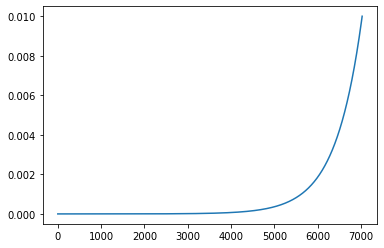

In [5]:
plt.plot(lr_find_lr)
plt.show()

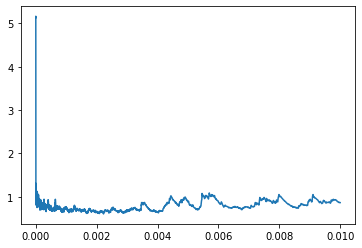

In [7]:
plt.plot(lr_find_lr, lr_find_loss)
plt.show()

6108
0.0022254808124576747


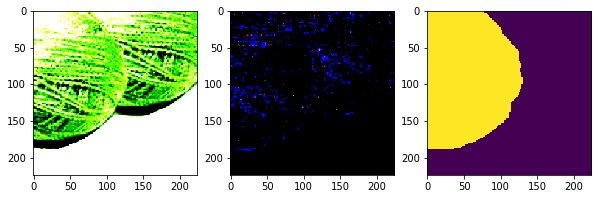

In [9]:
print(lr_find_loss.index(min(lr_find_loss)))
print(lr_find_lr[lr_find_loss.index(min(lr_find_loss))])

In [2]:
import utils
reload(utils)
from utils import stratified_train_val_test_split
import pretrain_dataset
reload(pretrain_dataset)
from pretrain_dataset import DATASET


df = pd.read_csv('pretrain_images.csv').sample(frac=1.0).reset_index(drop=True)
df_train, df_val, df_test = stratified_train_val_test_split(df, stratify_colname='class_idx', 
                                                                frac_train=0.96, frac_val=0.02, frac_test=0.02)

normalize = {
    "mean": [0.4535408213875562, 0.42862278450748387, 0.41780105499276865],
    "std": [0.2672804038612597, 0.2550410416463668, 0.29475415579144293],
}
transforms_normalize = albumentations.Compose(
    [
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    additional_targets={'ela':'image'}
)

valid_dataset = DATASET(
    dataframe=df_val,
    mode="val",
    transforms_normalize=transforms_normalize,
)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=12, pin_memory=True, drop_last=False)

val -> 11927


In [3]:
from segmentation.merged_net import SRM_Classifer
model = SRM_Classifer(num_classes=312)
model.eval();

In [4]:
inp = None
for ret in valid_loader:
    inp = ret
    break

In [20]:
from utils import topk_accuracy
from sklearn import metrics
from torchmetrics import MetricCollection, Accuracy, F1

image = inp['image']
ela = inp['ela']
# label = inp['label']
label = torch.tensor([33, 267, 100, 262, 95, 245, 232, 109])
print(image.shape, image.type())
print(ela.shape, ela.type())
print('label->', label.shape, label.type(), label)

out, _ = model(image, ela)
print("output->", out.shape, out.type())
pred = torch.argmax(out, dim=1)
print('argmax', pred.shape, pred)
sk_acc = metrics.accuracy_score(label, pred)
print(sk_acc)

top = topk_accuracy(out.cpu().detach(), label, topk=(1,5))
print(top)

met = col(torch.softmax(out.cpu().detach(), dim=-1), label)
print(met)

torch.Size([8, 3, 256, 256]) torch.FloatTensor
torch.Size([8, 3, 256, 256]) torch.FloatTensor
label-> torch.Size([8]) torch.LongTensor tensor([ 33, 267, 100, 262,  95, 245, 232, 109])
output-> torch.Size([8, 312]) torch.FloatTensor
argmax torch.Size([8]) tensor([292, 267,  67, 262,  95, 149, 232, 109])
0.625
[tensor([0.6250]), tensor([0.6250])]
{'Accuracy': tensor(0.6250), 'F1': tensor(0.6250)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Image_Manipulation_Dataset/FODB/extracted_images/D04_0022_JPEG_Double_Compression_160.jpg 98 JPEG_Double_CompressionQ = 61, 91
torch.Size([3, 256, 256]) torch.FloatTensor
torch.Size([3, 256, 256]) torch.FloatTensor


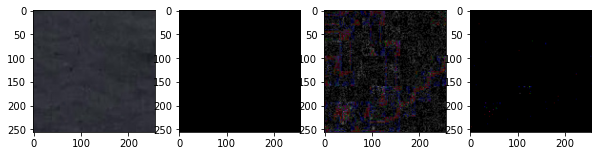

In [42]:
ret = valid_dataset[50]

image = ret['image']
ela = ret['ela']
label = ret['label']

print(ret['image_path'], label, ret['type'])
print(image.shape, image.type())
print(ela.shape, ela.type())

plt.figure(figsize=(10,20))
plt.subplot(1,4,1)
plt.imshow(ret['raw_image'])
plt.subplot(1,4,2)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,4,3)
plt.imshow(ret['raw_ela'])
plt.subplot(1,4,4)
plt.imshow(ela.permute(1,2,0))
plt.show()

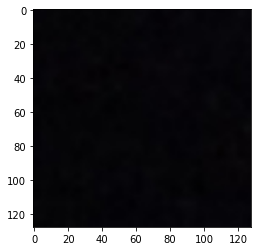

In [41]:
img = cv2.imread('Image_Manipulation_Dataset/FODB/extracted_images/D11_0052_Linear_Resize_29.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [12]:
df = pd.read_csv('dataset_csv/imd_64.csv')
df.label.value_counts()

0    89372
1    29997
Name: label, dtype: int64

In [5]:
mdl = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True)
)
summary(mdl, (3,256,256), device="cpu")

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 256, 256]        864
├─BatchNorm2d: 1-2                       [-1, 32, 256, 256]        64
├─ReLU: 1-3                              [-1, 32, 256, 256]        --
├─Conv2d: 1-4                            [-1, 32, 256, 256]        9,216
├─BatchNorm2d: 1-5                       [-1, 32, 256, 256]        64
├─ReLU: 1-6                              [-1, 32, 256, 256]        --
Total params: 10,208
Trainable params: 10,208
Non-trainable params: 0
Total mult-adds (M): 660.60
------------------------------------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 64.00
Params size (MB): 0.04
Estimated Total Size (MB): 64.79
------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 256, 256]        864
├─BatchNorm2d: 1-2                       [-1, 32, 256, 256]        64
├─ReLU: 1-3                              [-1, 32, 256, 256]        --
├─Conv2d: 1-4                            [-1, 32, 256, 256]        9,216
├─BatchNorm2d: 1-5                       [-1, 32, 256, 256]        64
├─ReLU: 1-6                              [-1, 32, 256, 256]        --
Total params: 10,208
Trainable params: 10,208
Non-trainable params: 0
Total mult-adds (M): 660.60
------------------------------------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 64.00
Params size (MB): 0.04
Estimated Total Size (MB): 64.79
------------------------------------------------------------------------------------------

In [19]:
with open('Image_Manipulation_Dataset/VISION/VISION_images.txt', 'r') as f:
    lines = f.read().splitlines()
len(lines)

11732

In [32]:
import requests

def dl(url):
    filename = url.split('/')[-1]
    dir = url.split('/', 5)[-1].rsplit('/', 1)[0]
    folder = os.path.join('Image_Manipulation_Dataset/VISION', dir)
    os.makedirs(folder, exist_ok=True)
    # print(filename, dir)
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(folder, filename), 'wb').write(r.content)
    # break


In [33]:
from functools import partial
from glob import glob
from multiprocessing.pool import Pool

with Pool(processes=os.cpu_count()) as p:
    with tqdm(total=len(lines)) as pbar:
        for v in p.imap_unordered(
            partial(
                dl
            ),
            lines,
        ):
            pbar.update()

100%|██████████| 11732/11732 [1:18:42<00:00,  2.48it/s]


In [3]:
from utils import get_dataframe

casia_full = get_dataframe('dataset_csv/casia_FULL.csv', folds=None)
imd_full = get_dataframe('dataset_csv/imd_FULL.csv', folds=None)
cmfd_full = get_dataframe('dataset_csv/cmfd_FULL.csv', folds=-1)
nist_full = get_dataframe('dataset_csv/nist16_FULL.csv', folds=None)
coverage_full = get_dataframe('dataset_csv/coverage_FULL.csv', folds=None)

nist_extend = get_dataframe('nist_extend.csv', folds=12)
coverage_extend = get_dataframe('coverage_extend.csv', folds=12)
defacto_cp = get_dataframe('dataset_csv/defacto_copy_move.csv', folds=-1)
defacto_inpaint = get_dataframe('dataset_csv/defacto_inpainting.csv', folds=-1)
defacto_s1 = get_dataframe('dataset_csv/defacto_splicing1.csv', folds=-1)
defacto_s2 = get_dataframe('dataset_csv/defacto_splicing2.csv', folds=-1)
defacto_s3 = get_dataframe('dataset_csv/defacto_splicing3.csv', folds=-1)


df_full = pd.concat([casia_full, imd_full, cmfd_full, nist_full, coverage_full, \
                nist_extend, coverage_extend, defacto_cp, \
                    defacto_inpaint, defacto_s1, defacto_s2, defacto_s3])
df_full.insert(0, 'image', '')
df_full = df_full[df_full['label'] == 1]

rows = df_full.values

In [9]:
def _filter_mask(data, count):
    temp_data = []

    removed_count, lines = 0 , []
    if os.path.exists("filtermask150.txt"):
        with open("filtermask50.txt", "r") as fp: lines = fp.read().splitlines()

    pbar = tqdm(data, desc="Filtering empty mask")
    for row in pbar:
        image_name, _, mask_patch, _, _, _, root_dir = row

        if mask_patch != '':
            mask_path = os.path.join('Image_Manipulation_Dataset', root_dir, image_name, mask_patch)
            if(not os.path.exists(mask_path)): print(f"Mask Not Found : {mask_path}")
            
            flag = 0
            if len(lines) > 0:
                if mask_path in lines: flag = 1
            else:
                mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if('NIST' in root_dir): mask_image = 255 - mask_image

                mask_image = augmentations.geometric.functional.resize(mask_image, 256, 256, cv2.INTER_AREA)
                if(np.count_nonzero(mask_image) < count): flag = 1
            
            if flag:
                removed_count += 1
                pbar.set_postfix({'removed': removed_count})
                continue
            
        temp_data.append(row)
            
    return temp_data
nonzero = _filter_mask(rows, 60)

Filtering empty mask: 100%|██████████| 102894/102894 [03:14<00:00, 527.73it/s, removed=2003]


In [11]:
print(len(rows))
print(len(nonzero))

102894
100891


In [3]:
from torchvision import transforms
transTensor = transforms.ToTensor()

In [14]:
nonzero2 = []
for row in tqdm(rows):
    image_name, image_patch, mask_patch, label, _, ela, root_dir = row

    mask_path = os.path.join('Image_Manipulation_Dataset', root_dir, image_name, mask_patch)

    if(not os.path.exists(mask_path)): print(f"Mask Not Found : {mask_path}")
    
    mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if('NIST' in root_dir):
        mask_image = 255 - mask_image

    mask_image = augmentations.geometric.functional.resize(mask_image, 256, 256, cv2.INTER_AREA)
    tensor_mask = transTensor(mask_image)

    if(np.count_nonzero(tensor_mask.numpy().ravel() >= 0.5) < 60):
        nonzero2.append(mask_path)
        # print(mask_path)

100%|██████████| 102894/102894 [03:29<00:00, 489.98it/s]


In [15]:
len(nonzero2)

5539

In [41]:
with open("filtermask50.txt", 'w') as file_handler:
    for item in nonzero2:
        file_handler.write("{}\n".format(item))

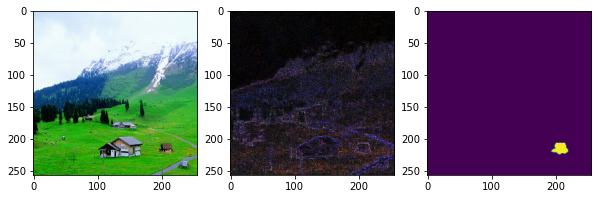

In [46]:
ROOT = 'I:/image_manipulation/'

image = cv2.imread(ROOT+'Image_Manipulation_Dataset/CASIA_2.0/Tp/Tp_D_NNN_S_N_nat20015_nat20018_01519.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256,256))

ela = cv2.imread(ROOT+'Image_Manipulation_Dataset/CASIA_2.0/Tp/Tp_D_NNN_S_N_nat20015_nat20018_01519_ela.jpg')
ela = cv2.cvtColor(ela, cv2.COLOR_BGR2RGB)
ela = cv2.resize(ela, (256,256))

mask = cv2.imread(ROOT+'Image_Manipulation_Dataset/CASIA_2.0/Gt/Tp_D_NNN_S_N_nat20015_nat20018_01519_gt.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(ela)
plt.subplot(1,3,3)
plt.imshow(mask)
plt.show()

# image = augmentations.geometric.functional.resize(image, 256, 256, cv2.INTER_AREA)
# mask = augmentations.geometric.functional.resize(mask, 256, 256, cv2.INTER_AREA)
# ela = augmentations.geometric.functional.resize(ela, 256, 256, cv2.INTER_AREA)

# print(image.shape, image.dtype)
# print(ela.shape, ela.dtype)
# print(mask.shape, mask.dtype)

In [18]:
from dataset import DATASET
from utils import get_dataframe, get_train_transforms


casia_full = get_dataframe('dataset_csv/casia_FULL.csv', folds=None)
casia_full.insert(0, 'image', '')
train_imgaug, train_geo_aug = get_train_transforms()

train_dataset = DATASET(
    dataframe=casia_full,
    mode="train",
    val_fold=0,
    test_fold=1,
    segment=False,
    transforms_normalize=None,
    imgaug_augment=train_imgaug,
    geo_augment=train_geo_aug,
    supcon=True,
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)

Filtering empty mask: 100%|████████████████████| 10073/10073 [00:01<00:00, 9625.57it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
0.9


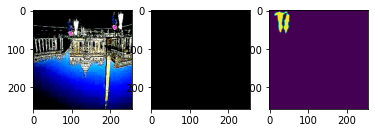

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


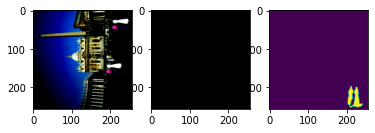

In [22]:
print(train_dataset[15]['label'])
plt.figure()
plt.subplot(1,3,1)
plt.imshow(train_dataset[15]['image'][0].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(train_dataset[15]['ela'][0].permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(train_dataset[15]['mask'][0].permute(1,2,0))
plt.show()

plt.figure()
plt.subplot(1,3,1)
plt.imshow(train_dataset[15]['image'][1].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(train_dataset[15]['ela'][1].permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(train_dataset[15]['mask'][1].permute(1,2,0))
plt.show()

In [25]:
for batch in train_loader:
    images = batch["image"]
    elas = batch["ela"]
    gt = batch["mask"]
    target_labels = batch["label"]

    print(images[0].shape)
    print(target_labels.shape)
    break

torch.Size([4, 3, 256, 256])
torch.Size([4])


In [1]:
from segmentation.merged_net import SRM_Classifer

model = SRM_Classifer(num_classes=1)

In [3]:
out_logits, (features, _, _, _, _) = model(torch.randn((8,3,256,256)), torch.randn((8,3,256,256)))

In [4]:
features.shape

torch.Size([8, 256])

In [3]:
import segmentation_models_pytorch as smp

encoder = smp.encoders.get_encoder('timm-efficientnet-b4')

In [5]:
print(encoder)

EfficientNetEncoder(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Swish()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Swish()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): Swish()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(
        (con

In [9]:
features = encoder(torch.randn(1,3,256,256))
for f in features:
    print(f.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 48, 128, 128])
torch.Size([1, 32, 64, 64])
torch.Size([1, 56, 32, 32])
torch.Size([1, 160, 16, 16])
torch.Size([1, 448, 8, 8])


In [13]:
aux_params = dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.2,               # dropout ratio, default is None
    activation='sigmoid',      # activation function, default is None
    classes=1,                 # define number of output labels
)
upp = smp.UnetPlusPlus(encoder_name='timm-efficientnet-b4',
                       decoder_attention_type='scse',
                       in_channels=3,
                       classes=1,
                       aux_params=aux_params)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_aa-818f208c.pth" to C:\Users\sowme/.cache\torch\hub\checkpoints\tf_efficientnet_b4_aa-818f208c.pth
100%|██████████| 74.4M/74.4M [00:23<00:00, 3.28MB/s]


In [2]:
from dataset import DATASET
from utils import get_dataframe
from torch.utils.data import DataLoader

casia_full = get_dataframe('dataset_csv/casia_FULL.csv', folds=None)
casia_full.insert(0, 'image', '')

test_dataset = DATASET(
    dataframe=casia_full,
    mode="test",
    segment=False,
    val_fold=0,
    test_fold=1,
    transforms_normalize=None,
    equal_sample=True
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)

Filtering empty mask: 100%|██████████| 1022/1022 [00:13<00:00, 73.70it/s]


torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256]) tensor([0.9000, 0.9000, 0.1000, 0.1000, 0.1000, 0.9000, 0.1000, 0.1000, 0.9000,
        0.1000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000],
       dtype=torch.float64)
tensor([2, 3, 4, 6, 7, 9])
tensor([ 0,  1,  5,  8, 10, 11, 12, 13, 14, 15])
torch.Size([6, 1, 256, 256]) torch.Size([10, 1, 256, 256])


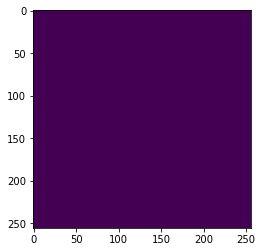

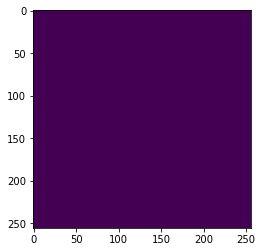

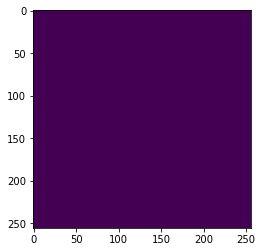

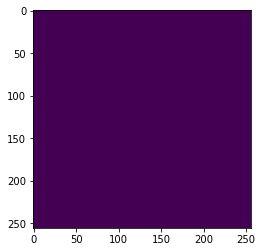

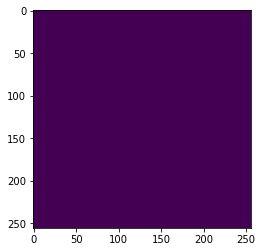

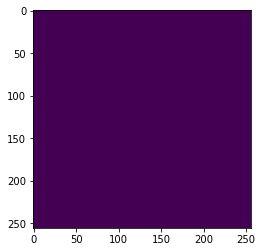

--------


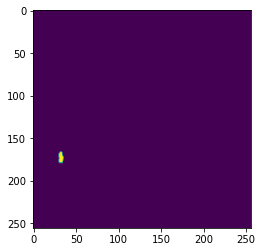

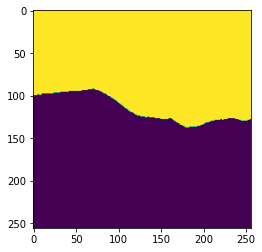

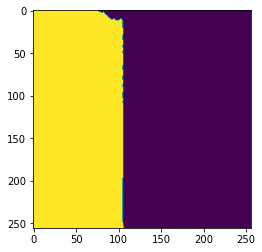

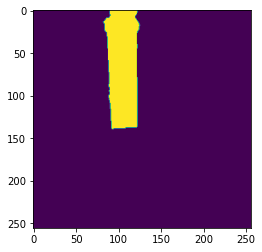

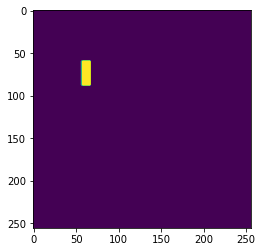

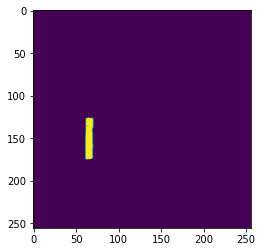

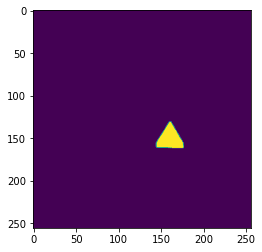

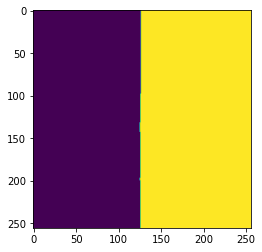

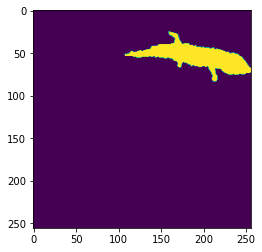

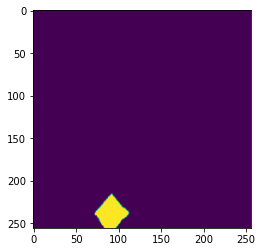

In [3]:
for data in test_loader:
    images = data["image"]
    elas = data["ela"]
    gt = data["mask"]
    target_labels = data["label"]
    print(images.shape, elas.shape, gt.shape, target_labels)
    
    real_indices = torch.where(target_labels < 0.5)[0]
    fake_indices = torch.where(target_labels > 0.5)[0]
    print(real_indices)
    print(fake_indices)
    real_images = gt[real_indices]
    fake_images = gt[fake_indices]
    print(real_images.shape, fake_images.shape)

    for im in real_images:
        plt.figure()
        plt.imshow(im.permute(1,2,0))
        plt.show()
    print("--------")
    for im in fake_images:
        plt.figure()
        plt.imshow(im.permute(1,2,0))
        plt.show()
    break 

In [56]:
pred = np.array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
true = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [32]:
confusion_matrix(true, pred)

array([[15,  1],
       [ 0,  0]], dtype=int64)

In [57]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
print(tp, fp, fn, tn)
print(fp/(fp+tn))
print((tp+tn)/(tp+tn+fp+fn))

2 2 2 10
0.16666666666666666
0.75


In [70]:
paths = ["abcd", "defg", "ggff", "avvd", "raaad", "dsfsdg", "sdv"]
indices = [2,3,5]
[paths[i] for i in indices]

['ggff', 'avvd', 'dsfsdg']